# Objectve Fine Tune the Bert model for NER

In [46]:
!pip install transformers datasets tokenizer seqeval -q

Using Conll-2003 dataset from huggingface.

This dataset has NER POS and chunking data. These datasets are lists of words they are pre-tokenized inputs that still need to go through the tokenizer for subwork tokeniztion.

https://huggingface.co/learn/nlp-course/chapter7/2


In [6]:
import datasets 
import numpy as np 
from transformers import BertTokenizerFast 
from transformers import DataCollatorForTokenClassification 
from transformers import AutoModelForTokenClassification

conll2003 = datasets.load_dataset("conll2003") 

## Transformer test
We will be using pretained bert . This means it already understand the english languange. It does this by archiving 2 things
 1. Masked language Model (MLM)-> ex: "Hello, `[MASK]` are you doing today?" it would output `how`
 2. Next Sentence Prediction (NSP)-> a) `[Joe is my friend]`. b) `[He lives in ottawa]` (Given sentence a and b. The model would be able to say yes sentence B follows sentence A) 

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") 

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

# Trans -> transformer, translation, transparent, transport, transcript ...

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']


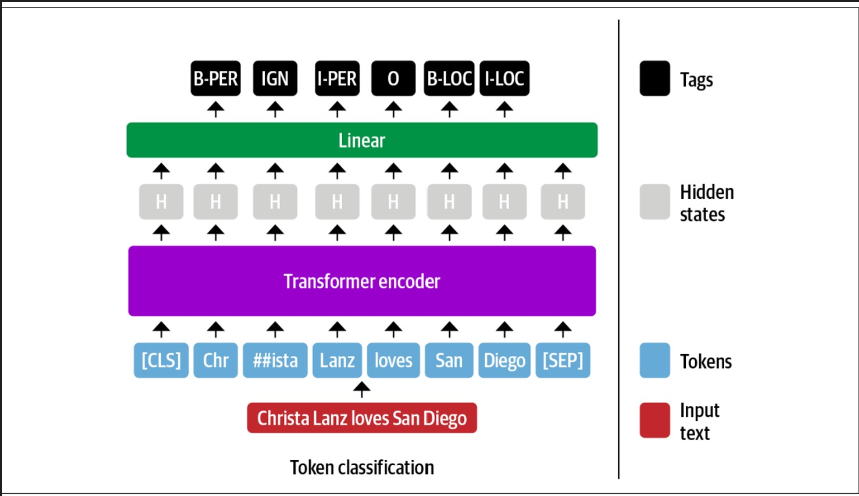
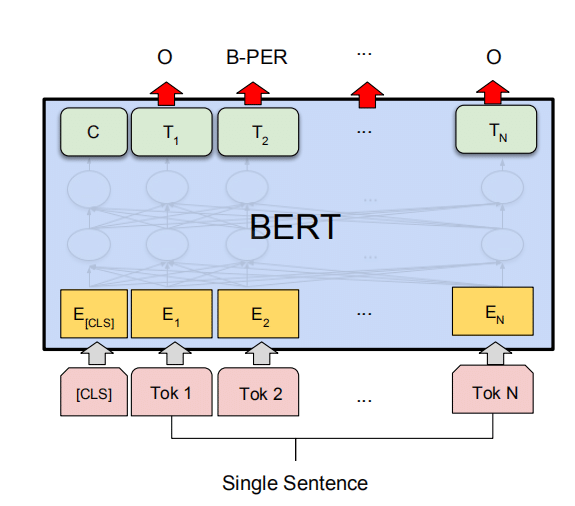

### Let's look at the first row of the database

In [47]:
conll2003["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

- `POS` -> Parts-Of-Speech
- `chunk_tags` -> Grouping of words to idenitfy grammatical role. "The cat is sleeping," -> it would group "the cat" to indicate that it is a noun phrase
- `ner_tag` -> Named Entity Recognition

In [17]:
tags=conll2003["train"].features["ner_tags"]
print(tags.feature.names)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [98]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased") 

### Here we print out the string, the tokenized value, the tokenized value back to a string as well as other data like the `token_type_ids`and `attention_mask`. 

In [19]:
example_text = conll2003["train"][0]
print(example_text["tokens"])

tokenized_input = tokenizer(example_text["tokens"],is_split_into_words=True) # is_split_into_words tells the tokenizer that our data is already split into words
print(tokenized_input["input_ids"])

tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"]) # 

print("########")
print(tokens)
print("########")

word_ids = tokenized_input.word_ids() 

print(word_ids)
tokenized_input

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102]
########
['[CLS]', 'eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.', '[SEP]']
########
[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, None]


{'input_ids': [101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Now let's compare the `example_text` length against the `tokenized_input` length

In [20]:
print(example_text['ner_tags'])
print(tokenized_input["input_ids"])

len(example_text['ner_tags']), len(tokenized_input["input_ids"]) 

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102]


(9, 11)

### We have a problem here
Our output of our tokenized_inputs is longer than our acctual input (example_text).

This can happen for 2 reason. 
  1. We have special tokens like the start and end tokens ('[CLS]' and '[SEP]') 
  2. When tokenizing our input it split a word like "Transformer" into 'Trans' and '##former'

---
## Our solution is a function that will aligns and Tokenizes our Dataset 

In [169]:
def tokenize_and_align_labels(examples, label_all_tokens=True): # label_all_tokens if a boolean that masks the subword representaion after the first subword 

    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)  # (truncation = true) means shorten the length of the input if it longer than the maximum length.
    labels = [] 
    for i, label in enumerate(examples["ner_tags"]): # loops over the examples["ner_tags"]
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        # word_ids => a list indicating the word corresponding to each token. 
        previous_word_idx = None 
        label_ids = []
        
        for word_idx in word_ids: 
            # Case 1: word_idx is equal to None (when we have a special token like '[CLS]' and '[SEP]') set to -100
            if word_idx is None: 
                label_ids.append(-100)
            # Case 2: Adds the token assigned to that word
            elif word_idx != previous_word_idx:    
                label_ids.append(label[word_idx]) 
            else: 
            # Case 3: It's a continuation of the previous word ('Trans', '##former')
                if label_all_tokens:
                    label_ids.append(label[word_idx])
                else:
                    # (##former) in (('Trans', '##former')) would have a tag of -100 and would be ignored) 
                    label_ids.append(-100)
            previous_word_idx = word_idx 
        labels.append(label_ids) 
    tokenized_inputs["labels"] = labels 
    return tokenized_inputs 

### Now if we run that same test we get (11,11)

In [120]:
q = tokenize_and_align_labels(conll2003['train'][0:1])

len(q["input_ids"][0]), len(q["labels"][0])# Comparing the length of the input and the tokenized output

(11, 11)

### Here we can see the `NER Tags` , `the input` and `the tokenized input`
 You will notice there are mutiple fields not only the `input_ids`. All of which provide critical data about our model.
<br>

 - `input_ids` : Tokenized values of the given input
 - `token_type_ids` : Used during Batching tells the trainer that these two words are in the same sequance. ex: `[CLS] HuggingFace is based in NYC [SEP] Where is HuggingFace based? [SEP]`
 - `attention_mask` : Used durring padding. If a sentence is shorter then the desired length padding will it with data and set the attention mask to 0 to indecate the data is duming data that was only used for padding.
 - `labels` : Numbers from 0-8 indecating what type of entity it is


In [121]:
q = tokenize_and_align_labels(conll2003['train'][:1])

print(len(q["input_ids"][0]), len(q["labels"][0]) )# Comparing the length of the input and the tokenized output

tags=conll2003["train"].features["ner_tags"]
print(tags.feature.names)
print(conll2003['train'][0]["tokens"])
print(q) 

11 11
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
{'input_ids': [[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]]}


## Lets take a look at the tokenized input value beside the NER tag ID

In [122]:
q = tokenize_and_align_labels(conll2003['train'][0:1]) 
print(q) 
print()

for token, label in zip(tokenizer.convert_ids_to_tokens(q["input_ids"][0]),q["labels"][0]): 
    print(f"{token:_<40} {label}") 

{'input_ids': [[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]]}

[CLS]___________________________________ -100
eu______________________________________ 3
rejects_________________________________ 0
german__________________________________ 7
call____________________________________ 0
to______________________________________ 0
boycott_________________________________ 0
british_________________________________ 7
lamb____________________________________ 0
._______________________________________ 0
[SEP]___________________________________ -100


### Hugging Face has a neat tool called `map` which allows us to apply this fuction to our entire dataset

In [135]:
tokenized_datasets = conll2003.map(tokenize_and_align_labels, batched=True)

Map: 100%|██████████| 3453/3453 [00:00<00:00, 11728.85 examples/s]


# Now we are ready to create our model

In [136]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=9)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Here we set some basic arguments for our Trainer

In [167]:
from transformers import TrainingArguments, Trainer 
args = TrainingArguments( 
"test-ner",
evaluation_strategy = "epoch", 
learning_rate=2e-5, 
per_device_train_batch_size=16, 
per_device_eval_batch_size=16, 
num_train_epochs=3, 
weight_decay=0.01, 
) 

### We use a data collator to format the data by adding padding and other things so that we can train our model faster 

In [138]:
data_collator = DataCollatorForTokenClassification(tokenizer) # Allows us to examine preprocess batches, and does things like applies padding

metric=datasets.load_metric("seqeval")
example=conll2003["train"][0]

c:\Users\joema\miniconda3\envs\nokia\lib\site-packages\datasets\load.py:752: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


## Now let's test the `metric.compute` function and make sure it is working properly

Here we are replacing the **ner tag ID** with the acctual **tag value** so we can test metric.compute with some data

In [139]:
label_list = conll2003["train"].features["ner_tags"].feature.names 
print( example["ner_tags"])
print(label_list)


labels = []
for i in example["ner_tags"]:
    labels.append(label_list[i])
labels

[3, 0, 7, 0, 0, 0, 7, 0, 0]
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


### Here we pass `labels` as prediction and references so our score should be 100%

In [140]:
metric.compute(predictions=[labels],references=[labels])

{'MISC': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

## We are now able to start training the model
We need to first make our own `compute_metric` as we are going to be using it with the trainer 

In [168]:
def compute_metrics(eval_preds): 
    pred_logits, labels = eval_preds 
    pred_logits = np.argmax(pred_logits, axis=2) 
    
    # Remove all the values where the label is -100 and reformat the data into a list within a list
    predictions = [
        [   label_list[eval_preds]
            for (eval_preds, l) in zip(prediction, label) 
            if l != -100
        ]
        for prediction, label in zip(pred_logits, labels)
    ]

    true_labels = [
        [ #Same thing but the only thing that changes is we start with label_list[l] and not label_list[eval_preds]
            label_list[l] 
            for (eval_preds, l) in zip(prediction, label) 
            if l != -100
        ]
        for prediction, label in zip(pred_logits, labels)
    ]
    results = metric.compute(predictions=predictions, references=true_labels) 
    print(results)
    return { 
   "precision": results["overall_precision"], 
   "recall": results["overall_recall"], 
   "f1": results["overall_f1"], 
  "accuracy": results["overall_accuracy"], 
  } 

In [142]:
trainer = Trainer( 
    model, 
    args, 
   train_dataset=tokenized_datasets["train"], 
   eval_dataset=tokenized_datasets["validation"], 
   data_collator=data_collator, 
   tokenizer=tokenizer, 
   compute_metrics=compute_metrics 
) 

## Now we train the model

In [144]:
trainer.train() 

 19%|█▉        | 500/2634 [00:41<02:55, 12.17it/s]

{'loss': 0.0782, 'learning_rate': 1.6203492786636296e-05, 'epoch': 0.57}


 33%|███▎      | 880/2634 [01:21<24:26,  1.20it/s]

{'eval_loss': 0.05834349989891052, 'eval_precision': 0.9294130724766563, 'eval_recall': 0.9353395234366261, 'eval_f1': 0.9323668804014495, 'eval_accuracy': 0.9839070964462167, 'eval_runtime': 5.0275, 'eval_samples_per_second': 646.45, 'eval_steps_per_second': 40.577, 'epoch': 1.0}


 38%|███▊      | 1000/2634 [01:31<02:19, 11.75it/s]

{'loss': 0.0562, 'learning_rate': 1.240698557327259e-05, 'epoch': 1.14}


 57%|█████▋    | 1500/2634 [02:15<01:36, 11.75it/s]

{'loss': 0.0333, 'learning_rate': 8.610478359908885e-06, 'epoch': 1.71}


 67%|██████▋   | 1758/2634 [02:44<12:09,  1.20it/s]

{'eval_loss': 0.0569528192281723, 'eval_precision': 0.9336058329650906, 'eval_recall': 0.9454077637319611, 'eval_f1': 0.9394697348674337, 'eval_accuracy': 0.9857816893577136, 'eval_runtime': 5.023, 'eval_samples_per_second': 647.018, 'eval_steps_per_second': 40.613, 'epoch': 2.0}


 76%|███████▌  | 2000/2634 [03:04<00:56, 11.30it/s]

{'loss': 0.0254, 'learning_rate': 4.8139711465451785e-06, 'epoch': 2.28}


 95%|█████████▍| 2500/2634 [03:50<00:10, 12.26it/s]

{'loss': 0.0199, 'learning_rate': 1.0174639331814731e-06, 'epoch': 2.85}


100%|██████████| 2634/2634 [04:12<00:00, 10.44it/s]

{'eval_loss': 0.05710927024483681, 'eval_precision': 0.9355229802711341, 'eval_recall': 0.9495469291867099, 'eval_f1': 0.94248278925161, 'eval_accuracy': 0.986226508014679, 'eval_runtime': 4.9957, 'eval_samples_per_second': 650.558, 'eval_steps_per_second': 40.835, 'epoch': 3.0}
{'train_runtime': 252.2849, 'train_samples_per_second': 166.966, 'train_steps_per_second': 10.441, 'train_loss': 0.041334653769647345, 'epoch': 3.0}


TrainOutput(global_step=2634, training_loss=0.041334653769647345, metrics={'train_runtime': 252.2849, 'train_samples_per_second': 166.966, 'train_steps_per_second': 10.441, 'train_loss': 0.041334653769647345, 'epoch': 3.0})

## Now we can save it so that we can use it using Hugging Faces `pipeline` function.

In [145]:
model.save_pretrained("ner_model_v2")

In [146]:
tokenizer.save_pretrained("tokenizer")

('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\vocab.txt',
 'tokenizer\\added_tokens.json',
 'tokenizer\\tokenizer.json')

In [147]:
id2label = {}
for i, label in enumerate(label_list):
    id2label[str(i)] = label

label2id = {}
for i, label in enumerate(label_list):
    label2id[label] = str(i)

In [148]:
import json

config = json.load(open("ner_model_v2/config.json"))

In [36]:
config["id2label"] = id2label
config["label2id"] = label2id

json.dump(config,open("ner_model_v2/config.json","w"))

model_fine_tuned_v2 = AutoModelForTokenClassification.from_pretrained("ner_model_v2")

# Version 2
This version achived much higher score as I had identified and resolved a mistake in my `tokenize and_align_labels()` function

In [170]:
from transformers import pipeline

nlp = pipeline("ner", model=model_fine_tuned_v2, tokenizer=tokenizer)


example = "Joseph Mansour goes to the University Of Ottawa in Ottawa Ontario Canada"

ner_results = nlp(example)

print(ner_results)

[{'entity': 'B-PER', 'score': 0.9987225, 'index': 1, 'word': 'joseph', 'start': 0, 'end': 6}, {'entity': 'I-PER', 'score': 0.9984498, 'index': 2, 'word': 'mans', 'start': 7, 'end': 11}, {'entity': 'I-PER', 'score': 0.9984138, 'index': 3, 'word': '##our', 'start': 11, 'end': 14}, {'entity': 'B-ORG', 'score': 0.97105026, 'index': 7, 'word': 'university', 'start': 27, 'end': 37}, {'entity': 'I-ORG', 'score': 0.9934638, 'index': 8, 'word': 'of', 'start': 38, 'end': 40}, {'entity': 'I-ORG', 'score': 0.98931026, 'index': 9, 'word': 'ottawa', 'start': 41, 'end': 47}, {'entity': 'B-LOC', 'score': 0.98885405, 'index': 11, 'word': 'ottawa', 'start': 51, 'end': 57}, {'entity': 'B-LOC', 'score': 0.9252537, 'index': 12, 'word': 'ontario', 'start': 58, 'end': 65}, {'entity': 'B-LOC', 'score': 0.9613258, 'index': 13, 'word': 'canada', 'start': 66, 'end': 72}]


`Test Cases`
- "Joseph Mansour goes to the University Of Ottawa in Ottawa Ontario Canada"
- "Steven says the best places to vist are Greece, Italy and France"
- "Microsoft just updated windows 11"
- "Apple Just released the new Iphone 16 in california"

# Version 1
This version achived much lower score as I had a problem with my `tokenize and_align_labels()` function that was later fixed.

In [ ]:
from transformers import pipeline

nlp = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer)


example = "bill gates works at microsoft"

ner_results = nlp(example)

print(ner_results)

[{'entity': 'B-LOC', 'score': 0.70316774, 'index': 3, 'word': 'works', 'start': 11, 'end': 16}, {'entity': 'B-LOC', 'score': 0.2689496, 'index': 4, 'word': 'at', 'start': 17, 'end': 19}, {'entity': 'I-PER', 'score': 0.58283514, 'index': 5, 'word': 'microsoft', 'start': 20, 'end': 29}]


`Test Cases`
- "Joseph Mansour goes to the University Of Ottawa in Ottawa Ontario Canada"
- "Steven says the best places to vist are Greece, Italy and France"
- "Microsoft just updated windows 11"
- "Apple Just released the new Iphone 16 in california"